## **1) Imports and connection to Google services** 

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # Stop word cloud generations errors
%matplotlib inline
import seaborn 
import itertools
import collections
from itertools import chain
from collections import Counter
from wordcloud import WordCloud
import csv

from google.colab import drive
drive.mount('/content/drive')

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/drive


# **2) Parameters**

In [3]:
dir = '/content/drive/Othercomputers/My MacBook Pro/Documents/Research/Projects/LevothyroxSentimentAnalysis/Colab Notebooks finaux/data/' # Files directory (in/out)

top_size = 15
n_gram_size = 2
limit = 10
period = 'M'        # 'Y', 'M', 'Q'
show = True

# Data importing
df = pd.read_csv(dir + 'dataset_doctissimo_updated_all_cleaning_steps.csv')  #results in paper where based on dataset_doctissimo_updated.csv which contained stop words
print('\n*****************\nFile <dataset_doctissimo_updated_all_cleaning_steps.csv> has been loaded\n*****************')     



*****************
File <dataset_doctissimo_updated_all_cleaning_steps.csv> has been loaded
*****************


## **3) Functions : word occurence & history, n-gram & history and words cloud**



In [4]:
def word_occurence(df):
    # df['text'] is an instance of class 'pandas.core.series.Series'
    words = df['text'].str.split()  
    # words is an instance of class 'pandas.core.series.Series'
    full_list = list(itertools.chain(*words))
    counts = Counter(full_list)
    index = []
    values = []
    for key, item in counts.items():
        index.append(key)
        values.append(item)
    return pd.DataFrame(data={'occurence':values}, columns=['occurence'], index=index)
        
def n_gram(df, n_gram_size):
    # An n-gram is a contiguous sequence of n items from a given sample of text
    
    # df['text'] is an instance of class 'pandas.core.series.Series'
    tokens = ' '.join([text for text in df['text']])
    tokens = tokens.split()
    ngrams = zip(*[tokens[i:] for i in range(n_gram_size)])
    list = [' '.join(ngram) for ngram in ngrams]
    counts = Counter(list)
    index = []
    values = []
    for key, item in counts.items():
        index.append(key)
        values.append(item)       
    return pd.DataFrame(data={'occurence':values}, columns=['occurence'], index=index)

def words_cloud(df, show=False):
    # df['text'] is an instance of class 'pandas.core.series.Series'
    all_text = ' '.join([text for text in df['text']])
    wc = WordCloud(width=800, height=500,random_state=21, max_font_size=110, collocations=False).generate(all_text)
    fig = plt.figure(figsize=(20, 12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    if show:
        plt.show()
    return fig    

def word_occurence_history(df, period):
    df2 = None
    df3 =df.groupby(pd.Grouper(freq=period))
    for period, group in df3:
        df1 = word_occurence(group)
        df1.rename(columns={'occurence': period}, inplace=True)       
        if df2 is None :
            df2 = df1
        else:
            df2 = pd.concat([df2, df1], axis=1, join='outer', sort=True)      
    df2 = df2.fillna(0) 
    return df2   
 
def top_word_occurence_history(df, period, limit):
    df2 = None
    df = word_occurence_history(df, period)
    # Convert to percent of column total
    #df = df.div(df.sum(axis=0), axis=1).multiply(100)
    periods = list(df.columns)
    for per in periods :
        df1 = df.nlargest(limit, [per])                     # Period top rows  
        if df2 is None :
            df2 = df1
        else:
            df2 = pd.concat([df1, df2], join='inner')       # Concatenate period top 10
            
    df2 = df2.groupby(level=0).last()                       # Clean duplicate rows
    return df2   

def n_gram_history(df, n_gram_size, period):
    # n-gram : yearly analysis
    df2 = None
    df3 = df.groupby(pd.Grouper(freq=period))
    for period, group in df3:
        df1 = n_gram(group, n_gram_size)
        df1.rename(columns={'occurence': period}, inplace=True)
        if df2 is None :
            df2 = df1
        else:
            df2 = pd.concat([df2, df1], axis=1, join='outer', sort=True)  
    df2 = df2.fillna(0)
    return df2

def top_n_gram_history(df, n_gram_size, period, limit):
    # n-gram : yearly analysis
    df2 = None 
    df = n_gram_history(df, n_gram_size, period)
    # To convert to percent of column total, uncomment next line
    #df = df.div(df.sum(axis=0), axis=1).multiply(100)  
    for period in list(df.columns):
        df1 = df.nlargest(limit, [period])                      # Period top rows
        if df2 is None:
            df2 = df1
        else:
            df2 = pd.concat([df1, df2], join='inner')           # Concatenate period top 10
                
    df2 = df2.groupby(level=0).last()                           # Clean duplicate rows     
    return df2

def top_n_gram_history_2(df, n_gram_size, period, limit):
    # n-gram : yearly analysis
    df = n_gram_history(df, n_gram_size, period)
    df2 = pd.DataFrame()
    periods = list(df.columns)
    for period in periods:
        top_index_list = list(df.nlargest(limit, [period]).index)
        df2[period] = top_index_list
    return df2

def getCorrelations(df):
    # df : historical dataframe
    df_cor_data = []
    df = df.transpose()
    columns_list = list(df.columns)
    for i in range(0, len(columns_list)):
        col_1 = columns_list[i]
        for j in range (i+1, len(columns_list)):
            col_2 = columns_list[j]    
            df1 = pd.merge(df[col_1], df[col_2], left_index=True, right_index=True, how='inner', suffixes=('_left', '_right'))
            cor = df.corr()[col_1][col_2]
            df_cor_data.append({'Item 1':col_1, 'Item 2':col_2, 'correlation':cor})
            #cor = np.corrcoef(security_1.data.loc[start:end]['Log_Returns(AdjClose)'], security_2.data.loc[start:end]['Log_Returns(AdjClose)'])[1, 0]
    df_cor = pd.DataFrame(df_cor_data)
    df_cor = df_cor.sort_values(by='correlation', ascending=False)
    return df_cor
   
def getTopCorrelations(df):
    df = getCorrelations(df)
    df = df.loc[(df['correlation']>0.95)]
    df = df.sort_values(by='correlation', ascending=False)
    return df

def getTopCorrelations_2(df):
    df = df.transpose()
    dict = {}
    
    for year in range(2016, 2021):
        df0 = df.loc[df.index.year==year]
 
        df_cor_data = []    
        columns_list = list(df0.columns)
        for i in range(0, len(columns_list)):
            col_1 = columns_list[i]
            for j in range (i+1, len(columns_list)):
                col_2 = columns_list[j]    
                df1 = pd.merge(df0[col_1], df0[col_2], left_index=True, right_index=True, how='inner', suffixes=('_left', '_right'))
                cor = df0.corr()[col_1][col_2]
                df_cor_data.append({'Item 1':col_1, 'Item 2':col_2, 'correlation':cor})
                #cor = np.corrcoef(security_1.data.loc[start:end]['Log_Returns(AdjClose)'], security_2.data.loc[start:end]['Log_Returns(AdjClose)'])[1, 0]

        df_cor = pd.DataFrame(df_cor_data)
        df_cor = df_cor.sort_values(by='correlation', ascending=False)
        
        df_cor = df_cor.loc[(df_cor['correlation']>0.95)]
        #df_cor = df_cor.sort_values(by=['Item 1', 'Item 2'])
        dict[year] = df_cor
    return dict
def plot_occurence(df,figname):
  df.plot(kind='bar',stacked=False, figsize=(10,5),fontsize=13,width=0.7,color=['blue', 'mediumpurple', 'darkorchid', 'mediumvioletred', 'm'])
  plt.legend(["2016", "2017","2018","2019","2020"]);
  plt.savefig(dir + figname,bbox_inches = 'tight')

def plot_occurence_bigrams(df,fig_size,figname):
  df.plot(kind='barh',stacked=False, figsize=fig_size,fontsize=13,width=0.7,color=['blue', 'mediumpurple', 'darkorchid', 'mediumvioletred', 'm'])
  plt.legend(["2016", "2017","2018","2019","2020"]);
  plt.savefig(dir + figname,bbox_inches = 'tight')


## **3) Results**

In [5]:
df['date'] = pd.to_datetime(df['date']) # Cast date to datetime
df['text'] = df['text'].astype(str) # Cast text column to string
df = df.set_index('date') # Set date column as index



Words cloud after cleaning (2016-2020)


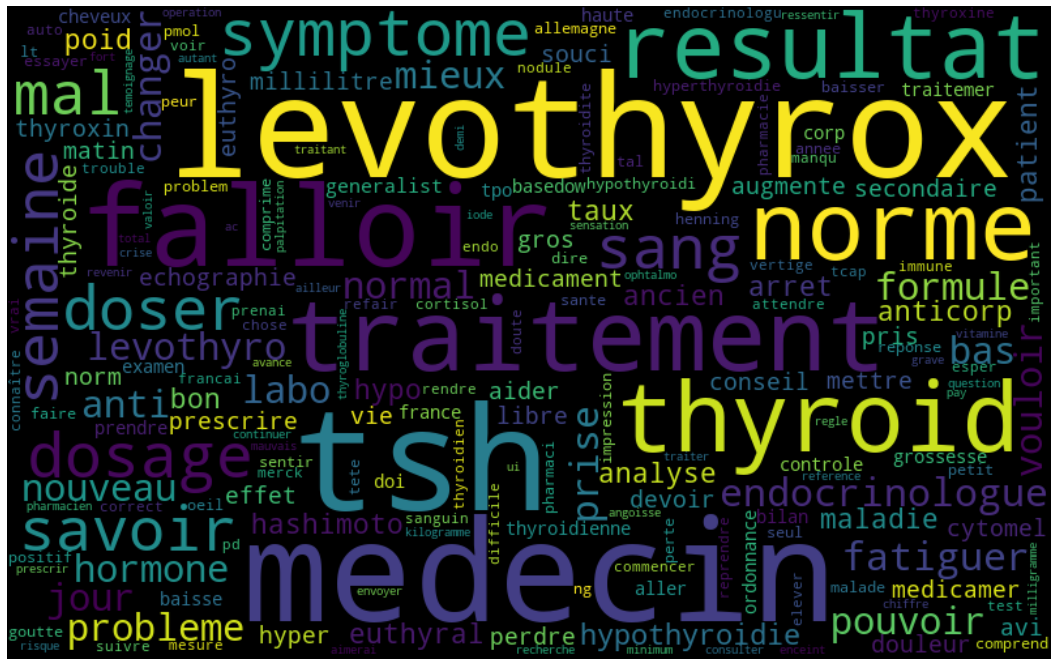

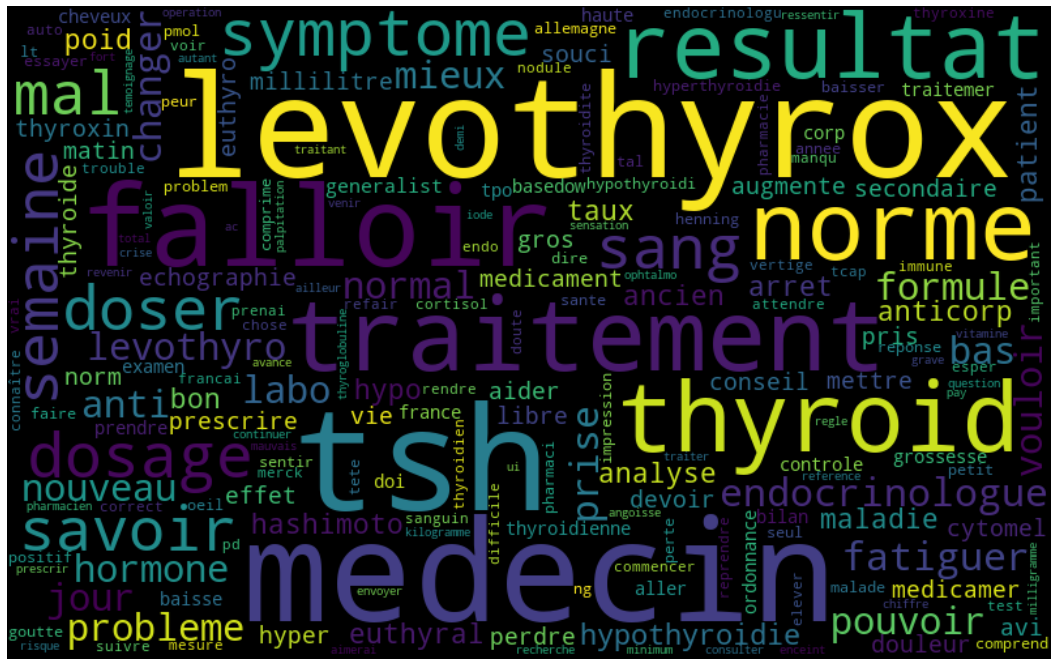

In [6]:
# Words cloud after cleaning
print('Words cloud after cleaning (2016-2020)')
words_cloud(df, True)



In [7]:
# Top word occurence
print()
print('Top word occurence')
print(word_occurence(df).nlargest(10, ['occurence']))
print()


Top word occurence
            occurence
tsh              2984
levothyrox       2947
medecin          2881
falloir          1684
traitement       1368
thyroid          1256
norme            1215
an               1068
resultat         1055
dosage           1000




Top_word_occurence_history
                2016-12-31  2017-12-31  2018-12-31  2019-12-31  2020-12-31
an                   218.0       450.0       239.0       157.0        22.0
cortisol              16.0        31.0        40.0        21.0        44.0
dosage               220.0       441.0       236.0        83.0        38.0
endocrinologue       289.0       333.0       282.0       120.0        36.0
falloir              333.0       713.0       383.0       118.0        37.0
fatiguer             201.0       326.0       185.0        95.0        47.0
formule                2.0       551.0       119.0        24.0         2.0
hypothyroidie        204.0       252.0       214.0       121.0        37.0
levothyrox           613.0      1882.0       498.0       248.0        41.0
mal                  159.0       455.0       197.0        80.0        21.0
medecin              511.0      1109.0       590.0       347.0        69.0
medicament            63.0       499.0       186.0        65.0        11

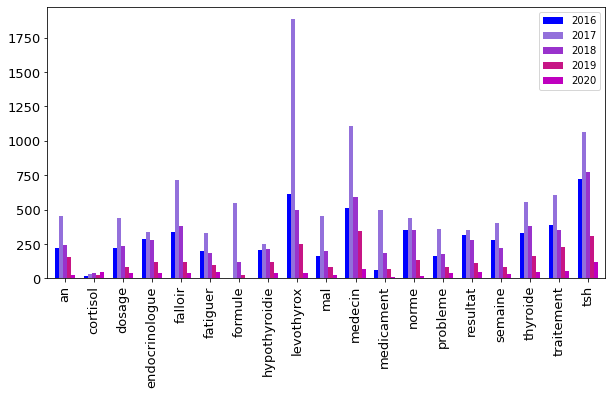

In [ ]:


# Top word occurence history
print()
print('Top_word_occurence_history')
#print(word_occurence_history(df, 'Y').nlargest(10, [2016, 2017, 2018, 2019, 2020]))
print(top_word_occurence_history(df, 'Y', 10))
plot_occurence(top_word_occurence_history(df, 'Y', 10),"/Figures/top_word_hist_Y.pdf")
print()


Top_word_occurence_history per Month
            2016-01-31  2016-02-29  ...  2020-02-29  2020-03-31
aider              4.0         9.0  ...         3.0         7.0
an                24.0        13.0  ...         8.0         7.0
ancien             1.0         2.0  ...         3.0         0.0
anti              24.0        17.0  ...        11.0         9.0
arret             22.0         7.0  ...         9.0         5.0
...                ...         ...  ...         ...         ...
traitement        59.0        57.0  ...        16.0        17.0
trouble            3.0         0.0  ...         1.0         0.0
tsh               82.0        70.0  ...        71.0        31.0
ui                 2.0        19.0  ...         0.0         4.0
vie                9.0        14.0  ...         3.0         7.0

[70 rows x 51 columns]



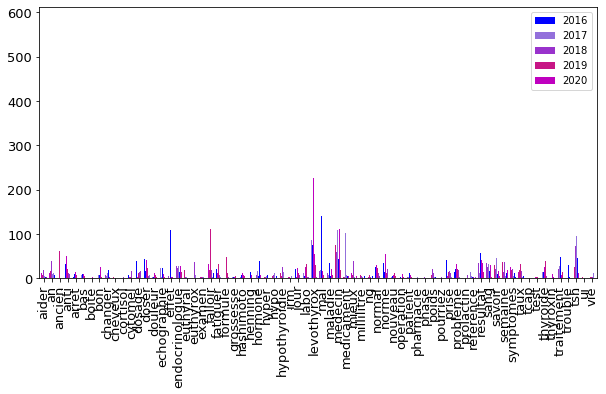

In [ ]:
# Top word occurence history per Month
print()
print('Top_word_occurence_history per Month')
#print(word_occurence_history(df, 'Y').nlargest(10, [2016, 2017, 2018, 2019, 2020]))
print(top_word_occurence_history(df, 'M', 10))
plot_occurence(top_word_occurence_history(df, 'M', 10),"/Figures/top_word_hist_M.pdf")
print()

In [ ]:
import altair as alt
from vega_datasets import data

source = data.barley()

source

,yield,variety,year,site
0,27.00000,Manchuria,1931,University Farm
1,48.86667,Manchuria,1931,Waseca
2,27.43334,Manchuria,1931,Morris
3,39.93333,Manchuria,1931,Crookston
4,32.96667,Manchuria,1931,Grand Rapids
...,...,...,...,...
115,58.16667,Wisconsin No. 38,1932,Waseca
116,47.16667,Wisconsin No. 38,1932,Morris
117,35.90000,Wisconsin No. 38,1932,Crookston
118,20.66667,Wisconsin No. 38,1932,Grand Rapids


In [ ]:
alt.Chart(source).mark_bar().encode(
    x='sum(yield)',
    y='variety',
    color='site'
)

alt.Chart(...)


Top N-gram occurrence
                      occurence
prise sang                  561
nouveau formule             337
norme labo                  284
hormone thyroidienne        275
effet secondaire            242
anti tpo                    230
ancien formule              228
pris sang                   165
doser levothyrox            160
auto immun                  159



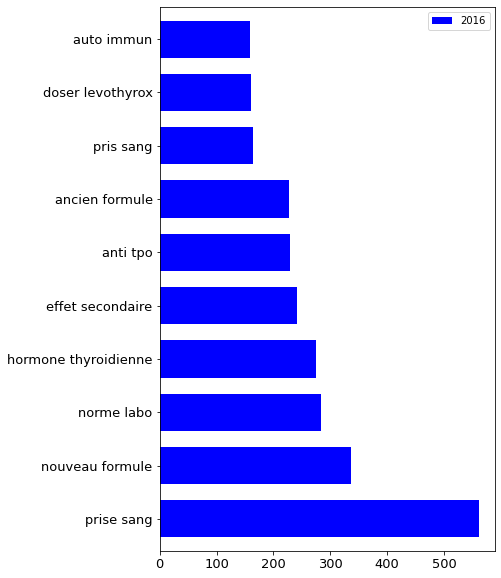

In [ ]:
# Top n-gram occurence
print()
print('Top N-gram occurrence')
print(n_gram(df, n_gram_size).nlargest(10, ['occurence']))
plot_occurence_bigrams(n_gram(df, n_gram_size).nlargest(10, ['occurence']),"/Figures/top_ngram_occurrence2.pdf")
print()




Top_n_gram_history
                      2016-12-31  2017-12-31  ...  2019-12-31  2020-12-31
ac anti                     26.0        25.0  ...         7.0         6.0
ancien formule               0.0       178.0  ...         7.0         1.0
ancien levothyro             0.0        92.0  ...         3.0         0.0
anti thyroperoxydase        35.0        31.0  ...        11.0         3.0
anti tpo                    79.0        78.0  ...        20.0         7.0
arret cytomel                1.0         9.0  ...         1.0         5.0
arret traitement            12.0        49.0  ...        17.0         3.0
auto immun                  40.0        53.0  ...        29.0         2.0
bas norme                   35.0        24.0  ...         9.0         0.0
doser levothyrox            50.0        84.0  ...        10.0         1.0
effet secondaire             8.0       183.0  ...        14.0         1.0
formule levothyrox           0.0        88.0  ...         7.0         1.0
hormone thyroidien

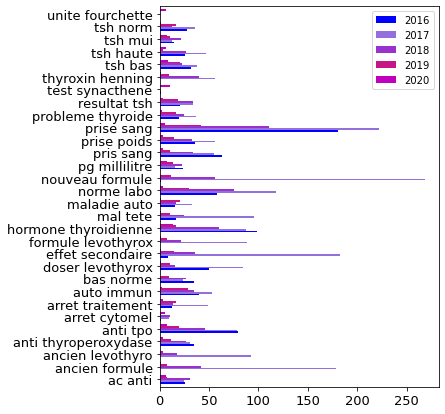

In [ ]:
# Top_n_gram_history
print()
print('Top_n_gram_history')
#print(n_gram_history(df, n_gram_size, 'Y').nlargest(10, [2016, 2017, 2018, 2019, 2020]))
print(top_n_gram_history(df, n_gram_size, 'Y', 10))
plot_occurence_bigrams(top_n_gram_history(df, n_gram_size, 'Y', 10),(5,7),"/Figures/top_n_gram_history.pdf")

print()



In [ ]:
# Top_n_gram_history_2
print()
print('Top_n_gram_history_2')
print(top_n_gram_history_2(df, n_gram_size, 'Y', 10))
top_n_gram_history_2(df, n_gram_size, 'Y', 10).to_csv(dir+"/Figures/Top_10_bigram_per_year.csv")
print()




Top_n_gram_history_2
             2016-12-31  ...            2020-12-31
0            prise sang  ...  hormone thyroidienne
1  hormone thyroidienne  ...       test synacthene
2              anti tpo  ...               tsh bas
3             pris sang  ...              anti tpo
4            norme labo  ...         pg millilitre
5      doser levothyrox  ...               tsh mui
6            auto immun  ...               ac anti
7           prise poids  ...             tsh haute
8  anti thyroperoxydase  ...      unite fourchette
9             bas norme  ...         arret cytomel

[10 rows x 5 columns]



In [ ]:
top_n_gram_history_2(df, n_gram_size, 'Y', 10)

,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31
0,prise sang,nouveau formule,prise sang,prise sang,hormone thyroidienne
1,hormone thyroidienne,prise sang,norme labo,norme labo,test synacthene
2,anti tpo,effet secondaire,hormone thyroidienne,auto immun,tsh bas
3,pris sang,ancien formule,nouveau formule,maladie auto,anti tpo
4,norme labo,norme labo,anti tpo,tsh bas,pg millilitre
5,doser levothyrox,mal tete,ancien formule,anti tpo,tsh mui
6,auto immun,ancien levothyro,thyroxin henning,resultat tsh,ac anti
7,prise poids,formule levothyrox,effet secondaire,arret traitement,tsh haute
8,anti thyroperoxydase,hormone thyroidienne,auto immun,probleme thyroide,unite fourchette
9,bas norme,doser levothyrox,pris sang,tsh norm,arret cytomel


In [ ]:
print()
print('Top word occurence correlations')
getCorrelations(top_word_occurence_history(df, 'Y', 10))






Top word occurence correlations


,Item 1,Item 2,correlation
36,dosage,falloir,0.999486
9,an,medecin,0.998296
129,mal,probleme,0.997950
59,endocrinologue,norme,0.997938
61,endocrinologue,resultat,0.995823
...,...,...,...
31,cortisol,semaine,-0.284009
19,cortisol,endocrinologue,-0.310343
30,cortisol,resultat,-0.330459
23,cortisol,hypothyroidie,-0.330511


In [ ]:
getTopCorrelations(top_word_occurence_history(df, 'Y', 10))


,Item 1,Item 2,correlation
36,dosage,falloir,0.999486
9,an,medecin,0.998296
129,mal,probleme,0.997950
59,endocrinologue,norme,0.997938
61,endocrinologue,resultat,0.995823
...,...,...,...
7,an,levothyrox,0.953812
114,hypothyroidie,traitement,0.953611
94,formule,levothyrox,0.953276
154,norme,traitement,0.952891


In [ ]:
print()
print('n_gram occurence correlations')
getCorrelations(top_n_gram_history(df, n_gram_size, 'Y', 10)).to_csv(dir+"/Figures/bigram_occurence_corr.csv")





n_gram occurence correlations


In [ ]:
print()
print('Top n_gram occurence correlations')
getTopCorrelations(top_n_gram_history(df, n_gram_size, 'Y', 10))





Top n_gram occurence correlations


,Item 1,Item 2,correlation
70,ancien levothyro,nouveau formule,0.999929
43,ancien formule,nouveau formule,0.999548
38,ancien formule,formule levothyrox,0.999310
29,ancien formule,ancien levothyro,0.999235
64,ancien levothyro,effet secondaire,0.998944
250,effet secondaire,nouveau formule,0.998847
268,formule levothyrox,nouveau formule,0.998842
65,ancien levothyro,formule levothyrox,0.998291
37,ancien formule,effet secondaire,0.997109
245,effet secondaire,formule levothyrox,0.996679


In [ ]:
#df1 = top_word_occurence_history(df, 'Y', 10).transpose()
#df1 = top_word_occurence_history(df, 'M', 5).transpose()
df1 = top_n_gram_history(df, 2, 'Q', 5).transpose()
#df1 = top_n_gram_history(df, 2, 'M', 10).transpose()
df1




,ancien formule,ancien levothyro,anti thyroglobuline,anti thyroperoxydase,anti tpo,application local,arret pilule,arret traitement,auto immun,doser levothyrox,douleur dos,effet secondaire,examen sang,extraire thyroidien,hormone thyroidienne,levothyrox tsh,maladie auto,millilitre phase,ng millilitre,norme labo,nouveau formule,pg millilitre,pris sang,prise poids,prise sang,test synacthene,thyroxin henning,trouble digestif,tsh bas,tsh haute,tsh norm,ui phase,ul millilitre
2016-03-31,0.0,0.0,6.0,4.0,24.0,0.0,0.0,4.0,8.0,19.0,0.0,4.0,0.0,0.0,39.0,2.0,2.0,0.0,1.0,23.0,0.0,5.0,25.0,10.0,67.0,1.0,0.0,0.0,8.0,7.0,5.0,0.0,3.0
2016-06-30,0.0,0.0,18.0,22.0,33.0,0.0,2.0,1.0,23.0,18.0,1.0,1.0,0.0,0.0,42.0,3.0,9.0,0.0,2.0,22.0,1.0,8.0,26.0,17.0,84.0,0.0,0.0,0.0,13.0,6.0,9.0,0.0,0.0
2016-09-30,0.0,0.0,7.0,7.0,21.0,0.0,0.0,4.0,7.0,13.0,0.0,3.0,0.0,0.0,16.0,5.0,3.0,0.0,2.0,10.0,0.0,9.0,6.0,4.0,16.0,0.0,0.0,0.0,8.0,1.0,6.0,0.0,14.0
2016-12-31,0.0,0.0,0.0,2.0,1.0,0.0,10.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,11.0,1.0,0.0,0.0,3.0,0.0,2.0,6.0,5.0,14.0,0.0,0.0,0.0,3.0,12.0,8.0,0.0,0.0
2017-03-31,0.0,0.0,8.0,15.0,35.0,0.0,3.0,2.0,11.0,22.0,0.0,5.0,0.0,0.0,31.0,4.0,5.0,0.0,2.0,26.0,1.0,3.0,9.0,8.0,42.0,1.0,0.0,0.0,18.0,15.0,12.0,0.0,3.0
2017-06-30,0.0,0.0,9.0,6.0,19.0,0.0,0.0,9.0,5.0,14.0,1.0,0.0,0.0,0.0,27.0,1.0,1.0,0.0,1.0,11.0,6.0,2.0,17.0,16.0,43.0,0.0,0.0,0.0,6.0,15.0,8.0,0.0,0.0
2017-09-30,107.0,55.0,4.0,6.0,11.0,0.0,1.0,21.0,15.0,34.0,0.0,117.0,16.0,1.0,11.0,9.0,13.0,0.0,1.0,23.0,159.0,1.0,17.0,20.0,55.0,0.0,0.0,3.0,5.0,5.0,6.0,0.0,3.0
2017-12-31,71.0,37.0,6.0,4.0,13.0,0.0,0.0,17.0,22.0,14.0,0.0,61.0,9.0,1.0,18.0,5.0,14.0,0.0,3.0,58.0,103.0,9.0,12.0,12.0,82.0,0.0,56.0,0.0,9.0,12.0,10.0,0.0,4.0
2018-03-31,12.0,14.0,6.0,14.0,14.0,18.0,0.0,5.0,10.0,9.0,0.0,8.0,5.0,0.0,18.0,4.0,5.0,0.0,2.0,32.0,22.0,13.0,9.0,7.0,35.0,0.0,15.0,24.0,6.0,10.0,5.0,0.0,0.0
2018-06-30,6.0,3.0,14.0,10.0,17.0,0.0,0.0,7.0,17.0,3.0,0.0,4.0,7.0,0.0,17.0,5.0,5.0,0.0,1.0,23.0,16.0,7.0,17.0,11.0,29.0,0.0,5.0,0.0,10.0,11.0,5.0,0.0,0.0


In [ ]:
df2 = pd.DataFrame(df1.stack(), columns=['Count']).reset_index()
df2.columns=['date','bi-gram','Count'] 
df2

,date,bi-gram,Count
0,2016-03-31,ancien formule,0.0
1,2016-03-31,ancien levothyro,0.0
2,2016-03-31,anti thyroglobuline,6.0
3,2016-03-31,anti thyroperoxydase,4.0
4,2016-03-31,anti tpo,24.0
...,...,...,...
556,2020-03-31,tsh bas,8.0
557,2020-03-31,tsh haute,6.0
558,2020-03-31,tsh norm,1.0
559,2020-03-31,ui phase,0.0


In [ ]:
import altair as alt

source = df2

base = alt.Chart(source).properties(width=800,height=400)
base.mark_line().encode(
    x='date',
    y='Count',
    color='bi-gram',
    strokeDash='bi-gram',
).configure_axis(
    labelFontSize=15,
    titleFontSize=20)

#chart.save(dir+'/Figures/plot_top_ngram_Q.pdf')


alt.Chart(...)

In [ ]:
!pip install altair_saver

     |████████████████████████████████| 89 kB 7.2 MB/s 
     |████████████████████████████████| 844 kB 48.0 MB/s 
     |████████████████████████████████| 958 kB 68.6 MB/s 
     |████████████████████████████████| 138 kB 59.2 MB/s 
     |████████████████████████████████| 356 kB 42.2 MB/s 
     |████████████████████████████████| 3.6 MB 45.6 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.

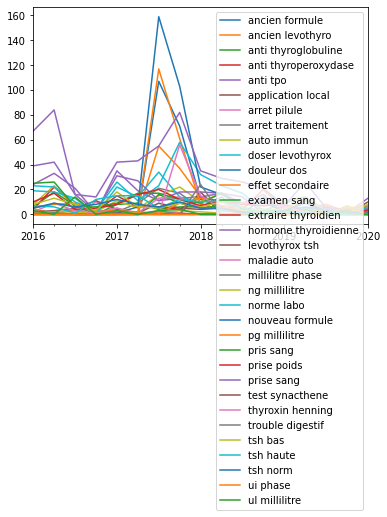

In [ ]:
df1.plot()
plt.show()

In [ ]:
data.stocks()


,symbol,date,price
0,MSFT,2000-01-01,39.81
1,MSFT,2000-02-01,36.35
2,MSFT,2000-03-01,43.22
3,MSFT,2000-04-01,28.37
4,MSFT,2000-05-01,25.45
...,...,...,...
555,AAPL,2009-11-01,199.91
556,AAPL,2009-12-01,210.73
557,AAPL,2010-01-01,192.06
558,AAPL,2010-02-01,204.62


In [ ]:
dict = getTopCorrelations_2(top_word_occurence_history(df, 'M', 50))
for year, df in dict.items():
    print()
    print(year)
    print(df)